In [1]:
import numpy

In [19]:
import pp_util

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [53]:
from numpy.random import default_rng
rng = default_rng(1234)
samples = numpy.append(rng.standard_normal(25)-0.5, rng.standard_normal(25)+0.5)
samples = sorted(filter(lambda x: x >= 0 and x <= 1.0, samples))

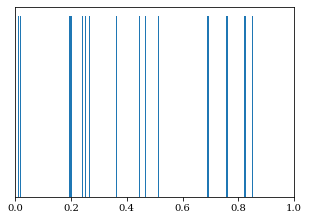

In [139]:
dpi=1
fig = plt.figure(figsize=(5.0*dpi,3.5*dpi))
ax = fig.add_subplot(1,1,1)
ax.bar(samples, 1.0, 0.005)
ax.set_yticks([])
ax.set_xlim([0,1])
plt.savefig("samples.png", dpi=300)

7.35807440813778 1.0000000518694219


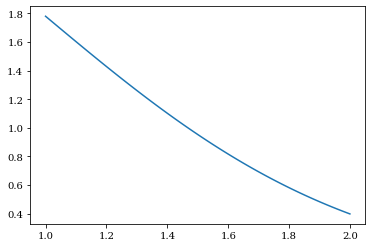

In [70]:

a,b = (1,2)
kx = numpy.linspace(a, b, 100)
scaling = pp_util.gaussian_scaling(a,b)
ky = scaling*pp_util.gaussian(kx)
plt.plot(kx,ky)
from scipy.integrate import simps

print(scaling, simps(ky, kx))

In [17]:
def bw_estimate(samples):
    sigma = numpy.std(samples)
    return ((4*sigma**5.0)/(3.0*len(samples)))**(1.0/5.0)

In [42]:
def kde(x, samples, hfunc, kernel=pp_util.gaussian, integral=False, boundary_fix=True):
    f_y = numpy.zeros(len(x))
    lim = (x[0], x[-1])
    for sx in samples:
        assert sx >= lim[0] and sx <= lim[1]
            
        loc_h = hfunc(sx)
        if boundary_fix:
             scaling = gaussian_scaling((lim[0]-sx)/loc_h,(lim[1]-sx)/loc_h)
        else:
            scaling = 1.0 
        if not integral:
            f_y += 1.0/loc_h * scaling * kernel((x-sx)/loc_h)
        else:
            f_y +=  scaling * ( kernel((x-sx)/loc_h)-kernel((lim[0]-sx)/loc_h))
    res = f_y/len(samples)
    return res

In [43]:
def kde_parts(x, samples, hfunc, kernel=pp_util.gaussian, integral=False, boundary_fix=True):
    f_y = numpy.zeros(len(x))
    lim = (x[0], x[-1])
    res = []
    for sx in samples:
        assert sx >= lim[0] and sx <= lim[1]
            
        loc_h = hfunc(sx)
        if boundary_fix:
             scaling = gaussian_scaling((lim[0]-sx)/loc_h,(lim[1]-sx)/loc_h)
        else:
            scaling = 1.0 
       
        res.append((1.0/loc_h * scaling * kernel((x-sx)/loc_h)))
    return res

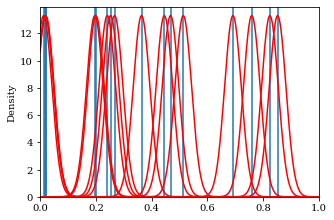

In [146]:
dpi=1
fig = plt.figure(figsize=(5.0*dpi,3.5*dpi))
ax = fig.add_subplot(1,1,1)

ax.set_xlim([0,1])
bw0 = 0.03 
x = numpy.linspace(0, 1, 1000)
f_ys = kde_parts(x, samples, lambda _: bw0, boundary_fix=False)
for s in samples:
    ax.axvline(s, 0.005)
for i in f_ys:
    ax.plot(x, i, color='red')
ax.set_ylim(bottom=0)
ax.set_ylabel("Density")
plt.savefig("samples-kern-bw-narrow.png", dpi=300)

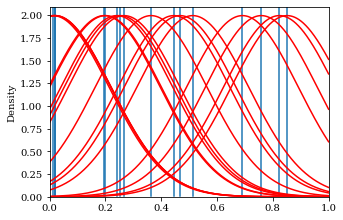

In [137]:
dpi=1
fig = plt.figure(figsize=(5.0*dpi,3.5*dpi))
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0,1])
bw0 = 0.2 
x = numpy.linspace(0, 1, 1000)
f_ys = kde_parts(x, samples, lambda _: bw0, boundary_fix=False)
for s in samples:
    ax.axvline(s,0.005)
for i in f_ys:
    ax.plot(x, i, color='red')
ax.set_ylim(bottom=0)
ax.set_ylabel("Density")
plt.savefig("samples-kern-bw-wide.png", dpi=300)

In [ ]:
import numpy
from scipy.integrate import simps

0.9344782404395614


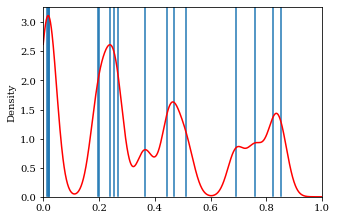

In [145]:
bw0 = 0.03
x = numpy.linspace(0, 1, 1000)
dpi=1
fig = plt.figure(figsize=(5.0*dpi,3.5*dpi))
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0,1])
f_y = kde(x, samples, lambda _: bw0, boundary_fix=False)
for s in samples:
    ax.axvline(s,0.005)
ax.plot(x, f_y, color='red')
ax.set_ylim(bottom=0)
ax.set_ylabel("Density")
plt.savefig("samples-kern-bw-narrow-recon.png", dpi=300)
print(simps(f_y,x))

0.81414943797099


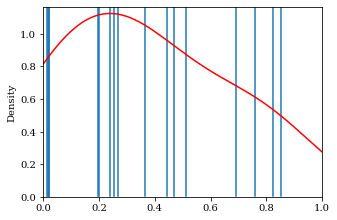

In [135]:
bw0 = 0.2
x = numpy.linspace(0, 1, 1000)
dpi=1
fig = plt.figure(figsize=(5.0*dpi,3.5*dpi))
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0,1])
f_y = kde(x, samples, lambda _: bw0, boundary_fix=False)
for s in samples:
    ax.axvline(s,0.005)
ax.plot(x, f_y, color='red')
ax.set_ylim(bottom=0)
ax.set_ylabel("Density")
plt.savefig("samples-kern-bw-wide-recon.png", dpi=300)
print(simps(f_y,x))

0.881708705465713


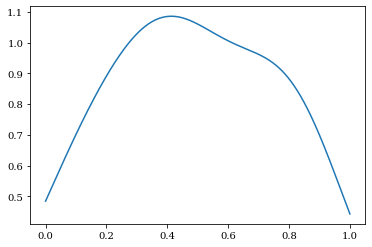

In [38]:
import scipy.stats
f_y_scipy = scipy.stats.gaussian_kde(samples)
plt.plot(x, f_y_scipy(x))
print(simps(f_y_scipy(x),x))

In [197]:
import pp_util
import importlib
importlib.reload(pp_util)
import pathlib

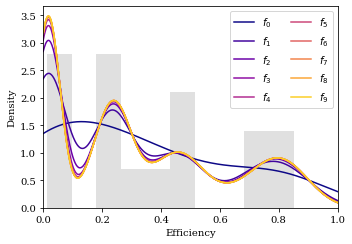

In [81]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(0,1,500), samples, 0.075)
fys = test_akde.pdf_series(10)
cm = plt.get_cmap("plasma")
ax = fig.add_subplot(1,1,1)
ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
#ax2 = plt.twinx()
ax.set_ylabel("Density")
ax.set_xlabel("Efficiency")
ax.set_xlim([0,1])
for i, p in enumerate(fys):
    if 1:#i == len(fs)-1:
        ax.plot(test_akde.x, p, label=f"$f_{i}$", c=cm(i/10.0))
ax.legend(loc='best',ncol=2)
plt.tight_layout()
plt.savefig("../../images/kde-progression.pdf", bbox_inches="tight")

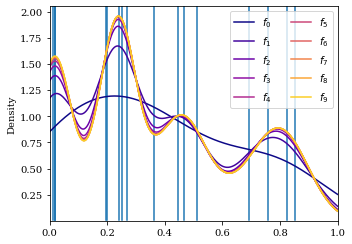

In [181]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(0,1,500), samples, 0.075)
test_akde.clip = False
fys = test_akde.pdf_series(10)
cm = plt.get_cmap("plasma")
ax = fig.add_subplot(1,1,1)
#ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
for s in samples:
    ax.axvline(s,0.005)
ax.set_ylabel("Density")
ax.set_xlim([0,1])
for i, p in enumerate(fys):
    if 1:#i == len(fs)-1:
        ax.plot(test_akde.x, p, label=f"$f_{i}$", c=cm(i/10.0))
ax.legend(loc='best',ncol=2)
plt.tight_layout()
plt.savefig("akde-progression.png", bbox_inches="tight", dpi=300)

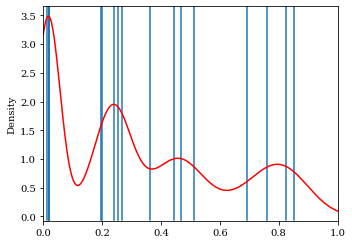

In [180]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(0,1,500), samples, 0.075)
fys = test_akde.pdf_series(10)
ax = fig.add_subplot(1,1,1)
#ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
for s in samples:
    ax.axvline(s,0.005)
ax.set_ylabel("Density")
ax.set_xlim([0,1])
for i, p in enumerate(fys):
    if i == len(fys)-1:
        ax.plot(test_akde.x, p,  c='red')
plt.tight_layout()
plt.savefig("akde-example-clipped.png", bbox_inches="tight", dpi=300)

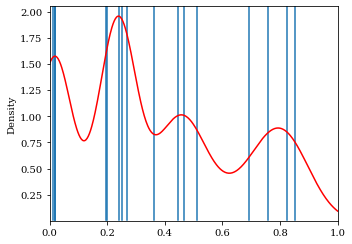

In [179]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(0,1,500), samples, 0.075)
test_akde.clip = False
fys = test_akde.pdf_series(10)
ax = fig.add_subplot(1,1,1)
#ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
for s in samples:
    ax.axvline(s,0.005)
ax.set_ylabel("Density")
ax.set_xlim([0,1])
for i, p in enumerate(fys):
    if i == len(fys)-1:
        ax.plot(test_akde.x, p,  c='red')
plt.tight_layout()
plt.savefig("akde-example-noclip.png", bbox_inches="tight", dpi=300)

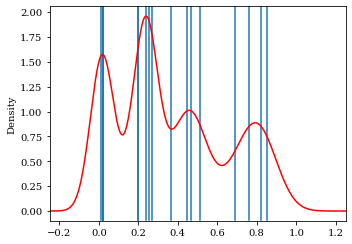

In [182]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(-0.5,1.5,500), samples, 0.075)
test_akde.clip = False
fys = test_akde.pdf_series(10)
ax = fig.add_subplot(1,1,1)
#ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
for s in samples:
    ax.axvline(s,0.005)
ax.set_ylabel("Density")
ax.set_xlim([-0.25,1.25])
for i, p in enumerate(fys):
    if i == len(fys)-1:
        ax.plot(test_akde.x, p,  c='red')
plt.tight_layout()
plt.savefig("akde-example-noclip-ext.png", bbox_inches="tight", dpi=300)

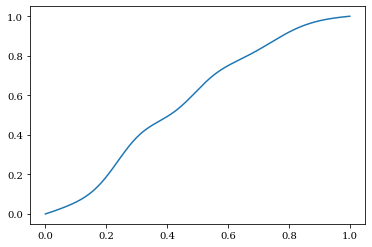

In [28]:
cdf = test_akde.cdf()
plt.plot(test_akde.x,cdf)

In [158]:
import os
qual_colormap = plt.get_cmap("tab10")
plat_colors=[(qual_colormap(i),name) for i,name in enumerate(["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"])]
csv_root = "../data/"

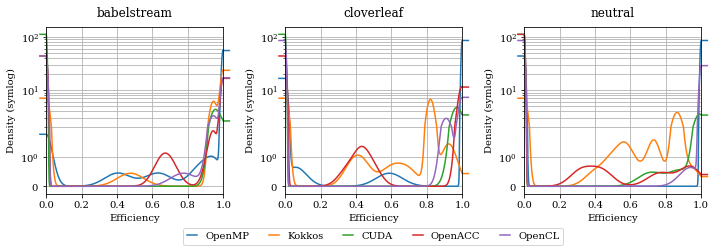

In [205]:
fig = plt.figure(figsize=(10, 3))
handles = {}
for i, fi in enumerate(["babelstream.csv", "cloverleaf.csv", "neutral.csv"]):
    ax = fig.add_subplot(1,3,i+1)
    effs = pp_util.get_effs(os.path.join(csv_root,fi), i==0)
    pp_util.plot_pdf(ax, effs, handles, plat_colors)
    ax.set_title(pathlib.Path(fi).stem,pad=10)
handles_names, handles_items = zip(*handles.items())
fig.legend(handles_items, handles_names, loc='upper left', ncol=5, handlelength=1.0, bbox_to_anchor=(0.25,0.0))
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
fig.savefig(f"../../images/akde_apps.png", bbox_inches="tight", dpi=300) 


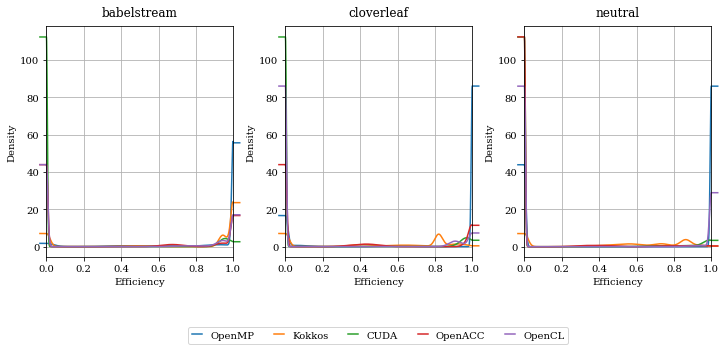

In [203]:
fig = plt.figure(figsize=(10, 5))
handles = {}
for i, fi in enumerate(["babelstream.csv", "cloverleaf.csv", "neutral.csv"]):
    ax = fig.add_subplot(1,3,i+1)
    effs = pp_util.get_effs(os.path.join(csv_root,fi), i==0)
    pp_util.plot_pdf(ax, effs, handles, plat_colors, symlog=False)
    ax.set_title(pathlib.Path(fi).stem,pad=10)
handles_names, handles_items = zip(*handles.items())
fig.legend(handles_items, handles_names, loc='upper left', ncol=5, handlelength=1.0, bbox_to_anchor=(0.25,0.0))
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
fig.savefig(f"../../images/akde_apps_linear.png", bbox_inches="tight",dpi=300) 


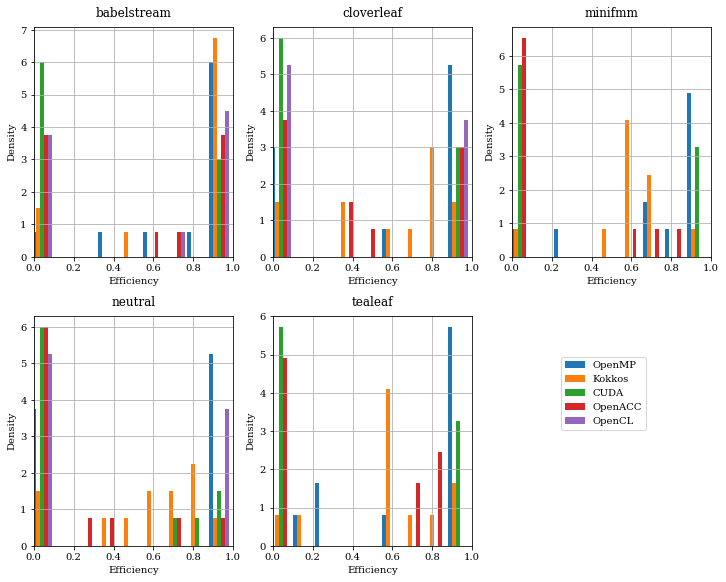

In [198]:
fig = plt.figure(figsize=(10, 8))
handles = {}
for i, fi in enumerate(["babelstream.csv", "cloverleaf.csv", "minifmm.csv", "neutral.csv", "tealeaf.csv"]):
    ax = fig.add_subplot(2,3,i+1)
    effs = pp_util.get_effs(os.path.join(csv_root,fi), i==0)
    pp_util.plot_bins(ax, effs, handles, plat_colors)
    ax.set_title(pathlib.Path(fi).stem,pad=10)
handles_names, handles_items = zip(*handles.items())
fig.legend(handles_items, handles_names, loc='lower right', bbox_to_anchor=(0.90,0.25))
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
#fig.savefig(f"../../images/akde_apps.pdf", bbox_inches="tight") 
#fig.savefig(f"../../images/akde_apps.pgf", bbox_inches="tight") 


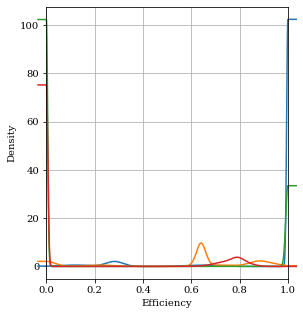

In [200]:
fig = plt.figure(figsize=(6, 5))
for i, fi in enumerate(["synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    effs, pp_util.read_effs(os.path.join(csv_root, fi))
    pp_util.plot_pdf(ax, effs, handles, symlog=False)
fig.savefig(f"../../images/akde_synthetic_linear.png", dpi=300, bbox_inches='tight') 

/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py:310: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if symlog:


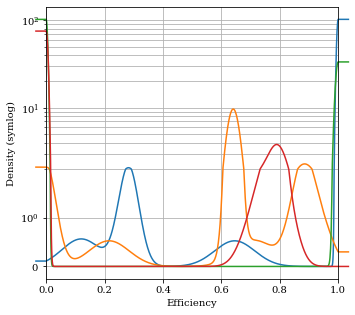

In [201]:
fig = plt.figure(figsize=(6, 5))
for i, fi in enumerate(["synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    effs, pp_util.read_effs(os.path.join(csv_root, fi))
    pp_util.plot_pdf(ax, effs, handles, symlog=True)
fig.savefig(f"../../images/akde_synthetic_linear.png", dpi=300, bbox_inches='tight') 

/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py:310: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if symlog:


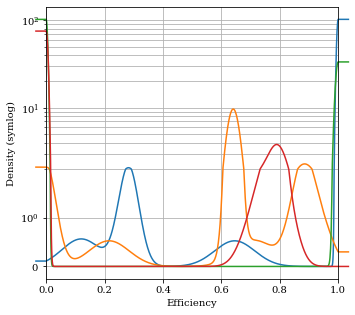

In [201]:
fig = plt.figure(figsize=(6, 5))
for i, fi in enumerate(["synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    effs, pp_util.read_effs(os.path.join(csv_root, fi))
    pp_util.plot_pdf(ax, effs, handles, symlog=True)
fig.savefig(f"../../images/akde_synthetic_linear.png", dpi=300, bbox_inches='tight') 

$$\mathrm{erf} x = \frac{2}{\pi}\int_0^x e^{-t^2} dt$$

$$ \Phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-\frac{1}{2}t^2}dt =  \frac{1}{2} \left(1+\mathrm{erf} \left(\frac{x}{\sqrt{2}}\right)\right) $$

$$ Y \int_{a}^{b} \frac{1}{h(s_i)\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-s_i}{h(s_i)}\right)^2} \,dx = 1 $$

$$ Y \frac{1}{h(s_i)\sqrt{2\pi}} \int_{a}^{b} e^{-\frac{1}{2}\left(\frac{x-s_i}{h(s_i)}\right)^2} \,dx = 1 $$

$$t = h(s_i)(x+s_i)$$
$$ Y \frac{1}{h(s_i)\sqrt{2\pi}} \int_{(a-s_i)/h(s_i)}^{(b-s_i)/h(s_i)} h(s_i) e^{-\frac{1}{2}t^2} \,dt = 1 $$
$$ Y \frac{1}{\sqrt{2\pi}} \int_{(a-s_i)/h(s_i)}^{(b-s_i)/h(s_i)} e^{-\frac{1}{2}t^2} \,dt = 1 $$
$$ Y \left(\Phi\left(\frac{b-s_i}{h(s_i)}\right) - \Phi\left(\frac{a-s_i}{h(s_i)}\right)\right) = 1 $$
$$ \frac{Y}{2} \left(\mathrm{erf}\left(\frac{b-s_i}{\sqrt{2}h(s_i)}\right) - \mathrm{erf}\left(\frac{a-s_i}{\sqrt{2}h(s_i)}\right)\right) = 1 $$
$$ Y = 2\left(\mathrm{erf}\left(\frac{b-s_i}{\sqrt{2}h(s_i)}\right) - \mathrm{erf}\left(\frac{a-s_i}{\sqrt{2}h(s_i)}\right)\right)^{-1} $$

$$ Y = 2\left(\mathrm{erf}\left(\frac{1}{\sqrt{2}x}\right)\right)^{-1} $$
$$ Y' = \frac{2}{\sqrt{2}x^2}\mathrm{erf}'\left(\frac{1}{\sqrt{2}x}\right)\left(\mathrm{erf}\left(\frac{1}{\sqrt{2}x}\right)\right)^{-2} $$
$$ Y' = \frac{2}{\sqrt{2}x^2}\frac{2}{\sqrt{\pi}}e^{-{\frac{1}{\sqrt{2}x}}^2}\left(\mathrm{erf}\left(\frac{1}{\sqrt{2}x}\right)\right)^{-2} $$
$$ Y' = \frac{4}{\sqrt{2\pi}x^2}e^{-{\frac{1}{\sqrt{2}x}}^2}\left(\mathrm{erf}\left(\frac{1}{\sqrt{2}x}\right)\right)^{-2} $$